#Analysis of San Francisco Bay Water Temperature
##By: Andrew R Cotter
##Last Updated: 01/2023

I am an avid open water swimmer based in the San Francisco Bay Area. Something that has a large impact on my day-to-day life is the water temperature of the San Francisco Bay. I prefer to swim without a wetsuit, and therefore the daily water temperate has a great impact on the total amount of time that I'm able to spend in the water without risking hypothermia.

Water temperatures are a source of great debate in the local open water community, so I thought that taking a data-driven look at long term historical trends as well as recent data would make for a fun activity.

All data is pulled from the hourly temperature data as measured by the buoy located on the west end of Crissy Field near the south tower of the Golden Gate Bridge (Station ID #9414290). This data is frely available on the [NOAA Website](https://tidesandcurrents.noaa.gov/physocean.html?id=9414290), and I've included all of the hourly data dating back to April 1994 in my analysis. The water in the Aquatic Park Cove (the most popular open water swimming spot in the area) is usually a couple of degrees F colder than this buoy, however I believe that the general trends should translate.

![buoy_location.jpg](buoy_location.jpg)



In [37]:
import pymc as pm
import arviz as az

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt

In [38]:
#Importing all of the yearly datafiles and stitching them together into a single Pandas dataframe
d1994 = pd.read_csv("data/water_temp/1994.csv")
d1995 = pd.read_csv("data/water_temp/1995.csv")
d1996 = pd.read_csv("data/water_temp/1996.csv")
d1997 = pd.read_csv("data/water_temp/1997.csv")
d1998 = pd.read_csv("data/water_temp/1998.csv")
d1999 = pd.read_csv("data/water_temp/1999.csv")
d2000 = pd.read_csv("data/water_temp/2000.csv")
d2001 = pd.read_csv("data/water_temp/2001.csv")
d2002 = pd.read_csv("data/water_temp/2002.csv")
d2003 = pd.read_csv("data/water_temp/2003.csv")
d2004 = pd.read_csv("data/water_temp/2004.csv")
d2005 = pd.read_csv("data/water_temp/2005.csv")
d2006 = pd.read_csv("data/water_temp/2006.csv")
d2007 = pd.read_csv("data/water_temp/2007.csv")
d2008 = pd.read_csv("data/water_temp/2008.csv")
d2009 = pd.read_csv("data/water_temp/2009.csv")
d2010 = pd.read_csv("data/water_temp/2010.csv")
d2011 = pd.read_csv("data/water_temp/2011.csv")
d2012 = pd.read_csv("data/water_temp/2012.csv")
d2013 = pd.read_csv("data/water_temp/2013.csv")
d2014 = pd.read_csv("data/water_temp/2014.csv")
d2015 = pd.read_csv("data/water_temp/2015.csv")
d2016 = pd.read_csv("data/water_temp/2016.csv")
d2017 = pd.read_csv("data/water_temp/2017.csv")
d2018 = pd.read_csv("data/water_temp/2018.csv")
d2019 = pd.read_csv("data/water_temp/2019.csv")
d2020 = pd.read_csv("data/water_temp/2020.csv")
d2021 = pd.read_csv("data/water_temp/2021.csv")
d2022 = pd.read_csv("data/water_temp/2022.csv")

d = pd.concat(
    [
        d1994, d1995, d1996, d1997, 
        d1998, d1999, d2000, d2001,
        d2002, d2003, d2004, d2005, 
        d2006, d2007, d2008, d2009,
        d2010, d2011, d2012, d2013,
        d2014, d2015, d2016, d2017,
        d2018, d2019, d2020, d2021,
        d2022
        ])


In [39]:
#Cleaning up the dataframe
d.rename(columns = {d.columns[0]:"date", d.columns[1]:"time", d.columns[2]: "temp"}, inplace = True)
d = d.loc[:,["date", "time", "temp"]]
d.loc[d.temp == "-","temp"] = np.nan
d.temp = d.temp.astype("float")
d.reset_index(inplace = True)

In [40]:
#Formatting year, month, day columns
d.date = pd.to_datetime(d.date)
d["year"] = d.date.dt.year
d["month"] = d.date.dt.month
d["day"] = d.date.dt.day
d["doy"] = d.date.dt.dayofyear

##First, lets take a look at some simple monthly averages.

In [46]:
#Calculating montly averages, year by year
monthly_average = d.groupby(by = ["year","month"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
monthly_average.sort_values(by = ["year", "month"], inplace = True)
monthly_average.reset_index(inplace = True)
monthly_average.dropna(inplace = True)
#monthly_average.year = pd.Categorical(monthly_average.year)

#Calculating the average of the monthly averages across all of the years
ma2 = monthly_average.groupby(by = "month", as_index = False).agg(Mean = ("Mean", np.mean))
ma2.sort_values(by = "month", inplace = True)
ma2.reset_index(inplace = True)

ma2

,index,month,Mean
0,0,1,52.367796
1,1,2,53.200513
2,2,3,54.045114
3,3,4,54.637911
4,4,5,55.557050
5,5,6,57.180054
6,6,7,59.498634
7,7,8,61.022001
8,8,9,61.329098
9,9,10,59.627547


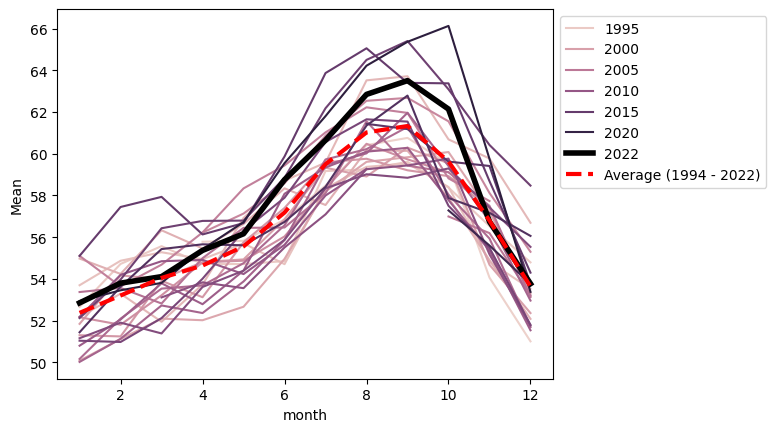

In [44]:
ax = sns.lineplot(data = monthly_average.loc[monthly_average.year<2022,:], x = "month", y = "Mean", hue = "year")
sns.lineplot(
    data = monthly_average.loc[monthly_average.year == 2022,:], 
    x = "month", y = "Mean", 
    linewidth = 4, color = "black", label = "2022"
    )
sns.lineplot(
    data = ma2, x = "month", y = "Mean", 
    linewidth = 3, color = "red", linestyle = "dashed", label = "Average (1994 - 2022)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Upon a quick glance, there are a few noteworthy features of this chart:
- On average, September is the warmest month as measured by the buoy, with an average temperature of 61.3&deg;F.  
- On the other side of the equation, January is the coldest, with an average temperature of 52.4&deg;F.  
- Generally, this location takes much longer to warm up than it does to cool off. With September being the warmest and January being the coldest, that 4 month period of rapid cooling. This is followed by an 8 month period of slow and steady warming.  
- Most of 2022 was warmer than average, especially during the late summer and early fall. However, this was followed by a steep decline in temperature in the months of November and December that brought the 2022 line back to to the historical average.  

In [30]:
#Calculating averages for each day for every DOY in the dataset
daily_average = d.groupby(by = ["year", "month", "day","doy"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
daily_average.sort_values(by = ["year","month","doy"], inplace = True)
daily_average.reset_index(inplace = True)




#Calculating yearly averages
yearly_average = d.groupby(by = ["year"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
yearly_average.sort_values(by = ["year"], inplace = True)
yearly_average.reset_index(inplace = True)

#Calculating hourly averages
hourly_average = d.groupby(by = ["time"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
hourly_average.sort_values(by = ["time"], inplace = True)
hourly_average.reset_index(inplace = True)

#Yearly MinMax
yearly_minmax = d.groupby(["year"], as_index = False).agg(Min = ("temp", np.min), Max = ("temp", np.max))
yearly_minmax.sort_values(by = ["year"], inplace = True)
yearly_minmax.reset_index(inplace = True)
yearly_minmax["diff"] = yearly_minmax.Max - yearly_minmax.Min


In [10]:
da2 = daily_average.groupby(by = ["doy"], as_index = False).agg(Mean = ("Mean", np.mean), Sd = ("Mean", np.std), N = ("Mean", len))
da2.sort_values(by = ["doy"], inplace = True)
da2.reset_index(inplace = True)

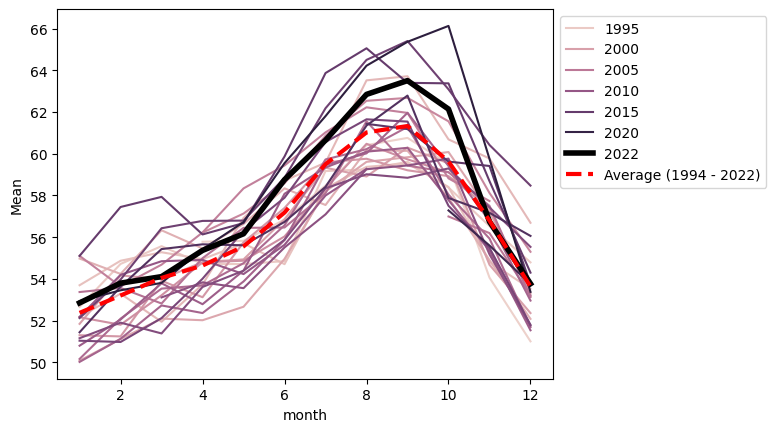

c:\Users\arcot\dev\venv\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


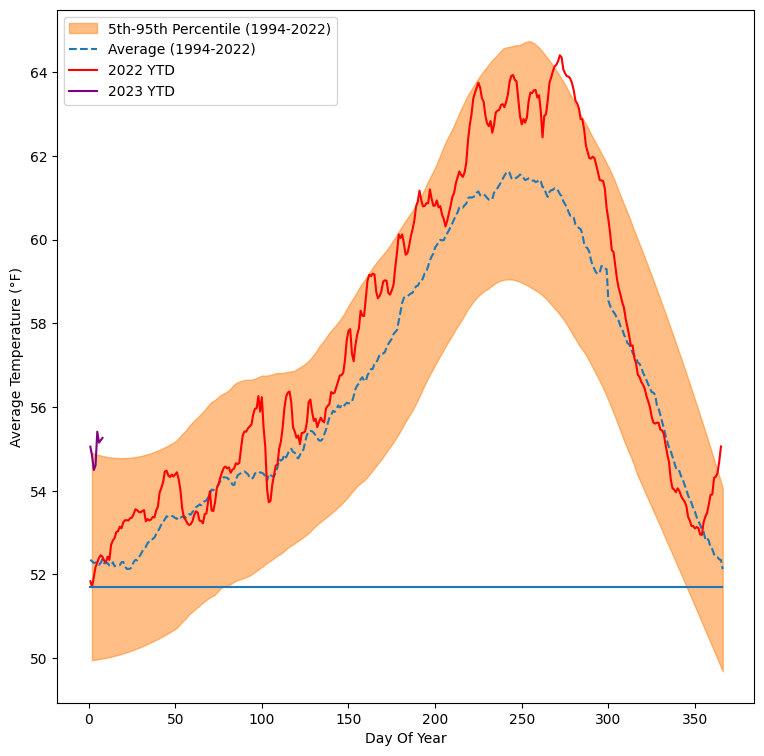

In [34]:
y = pd.DataFrame(daily_average.pivot(index = "year",columns = "doy", values = "Mean"))
y = y.fillna(y.mean())

fig, ax = plt.subplots(figsize = (9,9))
az.plot_hdi(x = da2.doy, y = y, hdi_prob = 0.9, fill_kwargs = {"label": "5th-95th Percentile (1994-2022)"})
plt.plot(da2.doy, da2.Mean, label = "Average (1994-2022)", linestyle = "--")
plt.plot(
    daily_average.loc[daily_average.year == 2022,"doy"],
    daily_average.loc[daily_average.year == 2022,"Mean"], 
    color = "Red", label = ("2022 YTD")
    )
plt.plot(
    daily_average.loc[daily_average.year == 2023,"doy"],
    daily_average.loc[daily_average.year == 2023,"Mean"], 
    color = "Purple", label = ("2023 YTD")
    )
ax.set_xlabel("Day Of Year")
ax.set_ylabel("Average Temperature (\N{DEGREE SIGN}F)")
ax.legend()
ax.hlines(y = daily_average.loc[daily_average.year == 2022,"Mean"].min(), xmin = 0, xmax = 366)

In [59]:
x = pd.DataFrame(monthly_average.pivot(index = "year",columns = "month", values = "Mean"))



In [70]:
y = pd.DataFrame(daily_average.pivot(index = "year",columns = "doy", values = "Mean"))

In [17]:
plt.Line2D?

Init signature:
plt.Line2D(
    xdata,
    ydata,
    linewidth=None,
    linestyle=None,
    color=None,
    marker=None,
    markersize=None,
    markeredgewidth=None,
    markeredgecolor=None,
    markerfacecolor=None,
    markerfacecoloralt='none',
    fillstyle=None,
    antialiased=None,
    dash_capstyle=None,
    solid_capstyle=None,
    dash_joinstyle=None,
    solid_joinstyle=None,
    pickradius=5,
    drawstyle=None,
    markevery=None,
    **kwargs,
)
Docstring:     
A line - the line can have both a solid linestyle connecting all
the vertices, and a marker at each vertex.  Additionally, the
drawing of the solid line is influenced by the drawstyle, e.g., one
can create "stepped" lines in various styles.
Init docstring:
Create a `.Line2D` instance with *x* and *y* data in sequences of
*xdata*, *ydata*.

Additional keyword arguments are `.Line2D` properties:

Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m,